# Proximity Tracing

This notebook shows how to perform proximity tracing using GeoAnalytics Server and the `run_python_script` tool. Given a starting entity (person, vehicle, ..), find all entities that have been near the starting entity. Repeat for each new entity visited.

In this specific example we'll be analyzing the tracks of four users near Portland, Maine.

#### The algorithm

1. Find all "proximity events" where any two entities are near each other within user specified proximity parameters. 
   This uses the join_features tool from GeoAnalytics.
2. Group consecutive proximity events into single sustained events.
3. Create a queue containing the user provided starting entities (entity_id and start_time). The queue will be appended 
   to as new entities are discovered.
4. For each entity in the queue (until empty): 
  1. Find all proximity events that involve the entity after the start time and then filter so that we only have 
     the earliest proximity event for each newly discovered entity.
  2. Queue all first proximity events for further processing. Also add each new entity to the result.
  
A function that implements this is defined below. This will be executed by GeoAnalytics Server using Spark. It will 
create several output feature layers containing the results of the trace. 

In [1]:
def proximity_tracing_rps():
    import json
    from heapq import heappush, heappop
    from pyspark.sql import functions as F
    from pyspark.sql import Window, SparkSession
    from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType
    from datetime import datetime, timedelta

    class ProximityTracing:
    
        def __init__(self, input_layer, entity_id_field, search_distance, search_duration, gap_tolerance=None,
                     additional_constraints=None):
    
            self.entity_id_field = entity_id_field
            self.search_distance = search_distance
            self.search_duration = search_duration
            self.gap_tolerance = gap_tolerance
            self.additional_constraints = additional_constraints
    
            self._init_observations(input_layer, entity_id_field)
            self._init_proximity_events()
            self._init_graph()
    
            self.spark = SparkSession.builder.getOrCreate()
    
        def trace(self, root_entities, max_depth):
    
            # as new proximity events are visited, they are added to the search queue with a priority ordering
            # based on the contact time. The ordering is necessary as multiple entities may come
            # in contact with the same entity at different times and we want to always process using
            # the earliest occurrence
            search_queue = []
    
            # maintains all entity ids that have been seen so that we only visit them once
            visited = set()
    
            # all new contacts are added here and returned as the result
            trace_result = []
    
            # initialize search queue and trace result with our root entities
            for (entity_id, start_time) in self._normalize_root_entities(root_entities):
                heappush(search_queue, (start_time, entity_id, 0, None))  # add to search queue with depth 0
                trace_result.append([None, entity_id, 0, 0.0, {"start": start_time, "end": start_time}, None])
    
            # keep searching until search queue is empty
            while search_queue:
    
                # get next track to process
                (start, entity_id, depth, result_row) = heappop(search_queue)
    
                # we've already processed this track so we can skip it
                if entity_id in visited:
                    continue
    
                # set as visited so we don't revisit and create a cycle
                visited.add(entity_id)
    
                # add to result (initial targets will not have a row in the result)
                if result_row:
                    trace_result.append(result_row)
    
                # do not search for contacts past the max depth
                if depth <= max_depth:
    
                    print("Processing entity %s from: %s, depth: %s"
                                     % (entity_id, start, depth))
    
                    next_proximity_events = self.graph.find_next_events(entity_id, start)
    
                    for (id, time, point) in next_proximity_events:
                        duration_minutes = round((time.end - time.start).total_seconds() / 60.0, 2)
                        result_row = (entity_id, id, depth + 1, duration_minutes, time, point)
                        heappush(search_queue, (time.start, id, depth + 1, result_row))
    
            new_schema = StructType([
                StructField("from_id", self.entity_id_datatype),
                StructField("to_id", self.entity_id_datatype),
                StructField("depth", IntegerType()),
                StructField("duration_minutes", DoubleType()),
                self._copy_field_schema(self.all_proximity_events, "$time", "$time"),
                self._copy_field_schema(self.observations, "$geometry", "$geometry")
            ])
    
            return self.spark.createDataFrame(trace_result, new_schema)
    
        def build_trace_tracks(self, trace):
    
            joined = self.observations.join(trace, [self.observations[self.entity_id_field] == trace.to_id,
                                                    self.observations["$time"].start >= trace["$time"].start])
    
            return joined.select(self.observations[self.entity_id_field], self.observations["$time"],
                                 self.observations["$geometry"], trace.depth)
    
        def _init_observations(self, input_layer, entity_id_field):
    
            # get all points that occur after our target search starting date
            if entity_id_field not in input_layer.schema.names:
                raise ValueError(
                    "Entity ID Field '%s' doesn't exist in Input Points (this value is case sensitive)" % entity_id_field)
    
            self.entity_id_datatype = input_layer.schema[entity_id_field].dataType
    
            self.observations = input_layer
    
        def _init_proximity_events(self):
    
            # add sequence number to observations grouped by entity ID and sorted by time
            window = Window.partitionBy(self.entity_id_field).orderBy(F.col("$time.start"))
            observations_sorted = self.observations.withColumn("series_index", F.row_number().over(window))
    
            # Use Join Features to find all proximity events in which an observation from one entity is near an observation
            # from another entity within the user defined parameters for proximity in both space and time.
            single_proximity_events = geoanalytics.join_features(observations_sorted, observations_sorted, "JoinOneToMany",
                                        spatial_relationship="NearGeodesic",
                                        spatial_near_distance=self.search_distance[0],
                                        spatial_near_distance_unit=self.search_distance[1],
                                        temporal_relationship="Near",
                                        temporal_near_distance=self.search_duration.total_seconds(),
                                        temporal_near_distance_unit="seconds",
                                        join_condition=self.additional_constraints) \
                .where(f"{self.entity_id_field} != join_{self.entity_id_field}") \
                .withColumnRenamed(self.entity_id_field, "from_id") \
                .withColumnRenamed(f"join_{self.entity_id_field}", "to_id")
    
            # Note that we now have a `from_id` and a `to_id`. The result of a self-join in the Join Features tool will
            # contain two records for each proximity event. Consider an situation where (A) and (B) are near each other -
            # (A) will be  returned as being near (B) and (B) will be returned as being near (A). The records would be
            # [(A,B),(B,A)].
    
            # We're using detect incidents to identify sustained proximity between two entities. The "track id" used to do
            # the calculation is [from_id, to_id]. This creates a "track" of all proximity events between two entities in
            # sorted order. Consecutive proximity events that occur within <break tolerance> of each other are merged
            # together into a single, sustained proximity event.
            # See: https://pro.arcgis.com/en/pro-app/tool-reference/big-data-analytics/detect-incidents.htm
    
            # If the start condition is 'true', every observation is a candidate for starting a new incident but only once
            # the end condition of the previous incident has been met (if applicable).
            start_condition = "true"
    
            # The end condition for the sustained proximity "incident" is when 1) we reach last record 2) the two points are
            # consecutive in the track or 3) the temporal difference between the current observation and the next
            # observation is greater than our tolerance.
            gap_tolerance_millis = 0
            if self.gap_tolerance:
                # odd but effective way to get the total milliseconds of a timedelta (there is no timedelta.milliseconds)
                gap_tolerance_millis = self.gap_tolerance / timedelta(milliseconds=1)
    
            end_condition = """
            var window = trackWindow(0, 2)
            var gap_tolerance_millis = %s

            if (count(window) == 1) {
                true // if our window length is 1 then we are at the end of the track
            } else if (window[0].series_index + 1 >= window[1].series_index) {
                false // these two events are consecutive
            } else if (gap_tolerance_millis > 0) {
                var currTime = startTime(window[0])
                var nextTime = startTime(window[1])
                // end event when the difference between this feature and the next is greater than our threshold
                datediff(nextTime, currTime) >= gap_tolerance_millis
            } else {
                true // two events are not consecutive and not within our break tolerance
            }
            """ % gap_tolerance_millis
            contact_incidents = geoanalytics.detect_incidents(single_proximity_events, ["from_id", "to_id"],
                                                              start_condition, end_condition)
    
            # The result of detect incidents has includes all observations tagged with an unique ID that now represents the
            # unique proximity events. We want a single summary record for each event.
            # Each record contains [from_id, to_id, start_location, start_time, end_time].
            contact_events = contact_incidents \
                .withColumn("first_geometry",
                            F.first("$geometry").over(Window.partitionBy("IncidentID").orderBy("$time.start"))) \
                .groupby("from_id", "to_id", "IncidentID") \
                .agg(F.min("$time.start").alias("contact_start"), F.max("$time.start").alias("contact_end"),
                     F.first("first_geometry").alias("$geometry", metadata=self.observations.schema["$geometry"].metadata)) \
                .withColumn("duration_minutes", F.round((F.unix_timestamp(F.col("contact_end")) -
                                                         F.unix_timestamp(F.col("contact_start"))) / 60, 2))
    
            self.all_proximity_events = self._with_time_as_interval(contact_events, "contact_start", "contact_end") \
                                            .select("from_id", "to_id", "duration_minutes", "$time", "$geometry")
    
        def _init_graph(self):
            self.graph = LocalGraph(self.all_proximity_events)
    
        # normalize the data type for the root entity ID provided by the user
        def _normalize_root_entities(self, root_entities):
            df = self.spark.createDataFrame(root_entities, ["entity_id", "start_time"])
            return df.select(F.col("entity_id").cast(self.entity_id_datatype), F.col("start_time")).collect()
    
        # copy schema of existing field with a new name (useful for complex types like $geometry)
        def _copy_field_schema(self, df, from_field, with_name):
            field = df.schema[from_field]
            return StructField(with_name, field.dataType, field.nullable, field.metadata)
    
        # convert start/end date fields into a time field that GA will recognize
        def _with_time_as_interval(self, df, start_time_field, end_time_field):
            projection = F.struct([F.col(start_time_field).alias("start"), F.col(end_time_field).alias("end")])
            return df.withColumn("$time", projection.alias("$time", metadata={"time": {"type": "interval"}}))\
                     .drop(start_time_field, end_time_field)
    
    class LocalGraph:
        """
    
        Builds a local graph using dictionaries. This approach is considerably faster than the data frame alternative
        but has the potential of overflowing memory on the Spark driver if there are lots of proximity events.
    
        The local graph is a directed multigraph. Each node represents a track (person,vehicle,...) and each edge between
        two nodes represents a proximity event (there can be multiple proximity events between nodes).
    
        Format:
    
        {
          "<from_id>" : {
            "<to_id>" : [(event_time, event_location), (event_time, event_location), ... ],
            "<to_id>" : [ ... ]
          },
          "<from_id>" : { ... },
          ...
        }
    
        """
    
        def __init__(self, all_proximity_events):
            self.all_proximity_events = all_proximity_events
            self._build_lookup()
    
        def _build_lookup(self):
            events_collected = self.all_proximity_events.collect()
    
            self.edges = {}
    
            for event in events_collected:
    
                from_track = self.edges.get(event.from_id)
                if not from_track:
                    from_track = {}
                    self.edges[event.from_id] = from_track
    
                to_track = from_track.get(event.to_id)
                if not to_track:
                    to_track = []
                    from_track[event.to_id] = to_track
    
                to_track.append((event["$time"], event["$geometry"]))
    
        def find_next_events(self, track_id, start):
    
            edge_from = self.edges.get(track_id)
            if not edge_from:
                return []
    
            next_events = []
    
            for edge_to in edge_from:
    
                min_event = None
                for event in edge_from.get(edge_to):
    
                    if event[0].end > start:
                        if not min_event or event[0].end < min_event[0].end:
                            min_event = event
    
                if min_event:
                    next_events.append((edge_to, min_event[0], min_event[1]))
    
            return next_events


    if __name__ == "__main__":

        input_layer = layers[0]
        parameters_layer = layers[1]

        # parse parameters from parameters layer
        parameters = [json.loads(row['params']) for row in parameters_layer.collect()][0]
        entity_id_field = parameters["entity_id_field"]
        search_distance = parameters["search_distance"]
        search_duration = timedelta(minutes=parameters["search_duration_minutes"])
        gap_tolerance = timedelta(minutes=parameters["gap_tolerance_minutes"])
        root_entities = [(i[0], datetime(i[1], i[2], i[3])) for i in parameters["root_entities"]]
        output_trace_events = parameters["output_trace_events"]
        output_all_proximity_events = parameters["output_all_proximity_events"]
        output_trace_tracks = parameters["output_trace_tracks"]

        max_depth = parameters.get("max_depth", 10000)

        # get earliest start time of all trace targets to filter out unnecessary records
        initial_start_time = min(map(lambda t: t[1], root_entities))
        input_layer_filtered = input_layer.where(F.col("$time.start") >= initial_start_time)

        tracing = ProximityTracing(input_layer_filtered, entity_id_field, search_distance, search_duration,
                                   gap_tolerance)

        # proximity events are always calculated so we can write them first if requested
        if output_all_proximity_events:
            print(f"Writing all proximity events to {output_all_proximity_events}...")
            tracing.all_proximity_events.write.format("webgis").save(output_all_proximity_events)

        print("Performing trace...")
        trace_events = tracing.trace(root_entities, max_depth)

        print(f"Writing trace events to {output_trace_events}...")
        trace_events.write.format("webgis").save(output_trace_events)

        if output_trace_tracks:
            trace_tracks = tracing.build_trace_tracks(trace_events)
            print(f"Writing trace tracks to {output_trace_tracks}...")
            trace_tracks.write.format("webgis").save(output_trace_tracks)


def run_tracing_script(entity_id_field, search_distance, search_duration_minutes, gap_tolerance_minutes,
                       root_entities, output_trace_events, output_all_proximity_events=None, output_trace_tracks=None,
                       max_depth=100):

    import json

    # RunPythonScript (at 10.8) only accepts layers as parameters - we can encode the script parameters as a local
    # feature collection to work around this limitation
    parameters = {
        "entity_id_field": entity_id_field,
        "search_distance": search_distance,
        "search_duration_minutes": search_duration_minutes,
        "gap_tolerance_minutes": gap_tolerance_minutes,
        "root_entities": root_entities,
        "output_trace_events": output_trace_events,
        "output_all_proximity_events": output_all_proximity_events,
        "output_trace_tracks": output_trace_tracks,
        "max_depth": max_depth
    }

    parameters_layer = {"featureSet": {"features": [{"attributes": {"params": json.dumps(parameters)}}]},
                        "layerDefinition": {"fields": [{"name": "params", "type": "esriFieldTypeString"}]}}

    # send script and parameters to server for processing
    run_python_script(code=proximity_tracing_rps, layers=[layer, parameters_layer])

#### Connect to our track data

In [2]:
import uuid
from arcgis.apps.tracker import TrackView
from arcgis.gis import GIS
from arcgis.geoanalytics.manage_data import run_python_script

gis = GIS("https://<server>/portal", "<username>", verify_cert=False)

# Provide a track view item id
layer = TrackView(gis.content.get("9a1503810b77473e8264d1c93266e295")).tracks_layer
layer.filter = "horizontal_accuracy <= 100 and location_timestamp > date '2020-04-24'"

Enter password: ········


#### Let's look at the tracks
You can see there are four users tracks and they come into proximity of each other at various locations. First Jane Doe (green tracks) who is the initial trace target drives to Portland and interacts with John Doe (blue tracks). Then John Doe drives to Bug Light Park and interacts with John Smith (purple tracks). Then John Smith drives to Fort Wiliams and interacts with Maria Garcia (red tracks). Finally Maria Garcia drives to Westbrook.


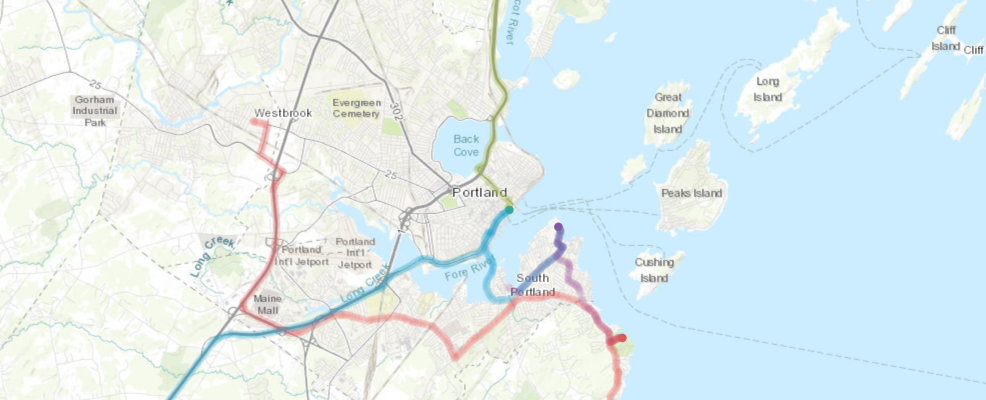

In [4]:
m = gis.map("Portland, ME", zoomlevel=12)
uvr = {"type":"uniqueValue","field1":"created_user","uniqueValueInfos":[
  {"value":"mgarcia","label":"mgarcia","symbol":{"color":[237,81,81,10],"size":6,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle"}},
  {"value":"johndoe","label":"johndoe","symbol":{"color":[20,158,206,10],"size":6,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle"}},
  {"value":"janedoe","label":"janedoe","symbol":{"color":[167,198,54,10],"size":6,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle"}},
  {"value":"johnsmith","label":"johnsmith","symbol":{"color":[158,85,156,10],"size":6,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle"}}
]}
m.add_layer(layer, {"renderer": uvr})
m

#### Execute the script
We'll now run the script using the GeoAnalytics Server. In this scenario we specified that `janedoe` was the intial target to start the trace with.

In [5]:
unique_id = str(uuid.uuid4())[:4]
output_trace_events_name = f"trace_events_{unique_id}"
output_all_proximity_events=f"all_proximity_events_{unique_id}"
output_trace_tracks=f"trace_tracks_{unique_id}"

run_tracing_script(
    # The name of the field uniquely identifying a set of tracks
    entity_id_field="created_user",
    # The search distance to be used when marking an entity as near another entity
    search_distance=[25, "feet"],
    # The duration of time to be used when marking an entity as near another entity
    search_duration_minutes=1,
    # The tolerance to use when splitting proximity events
    gap_tolerance_minutes=1,
    # The initial set of entities to begin the trace (identify)
    root_entities=[["janedoe", 2020, 4, 24]],
    # Proximity event locations where an entity was identified as being near the root or a derivative entity
    output_trace_events=output_trace_events_name,
    # All proximity event locations
    output_all_proximity_events=output_all_proximity_events,
    # The tracks after a user was identified as being near the root or a derivative entity
    output_trace_tracks=output_trace_tracks
)

#### View the results

The following table shows there were 3 proximity events. You can see that Jane Doe was in proxmity of John Doe who was then later in proximity with John Smith, who was then later in proximity to Maria Garcia. The depth indicates how many degrees of separation are between the intial target and the user.

In [6]:
trace_events_df = gis.content.search(output_trace_events_name, sort_field="modified", sort_order="desc")[0].layers[0].query(as_df=True, order_by_fields="START_DATETIME")
trace_events_df[['from_id', 'to_id', 'depth', 'START_DATETIME', 'END_DATETIME', 'SHAPE']]

,from_id,to_id,depth,START_DATETIME,END_DATETIME,SHAPE
0,None,janedoe,0,2020-04-24 07:00:00,2020-04-24 07:00:00,None
1,janedoe,johndoe,1,2020-04-25 09:28:40,2020-04-25 09:59:09,"{""x"": -70.25112661914547, ""y"": 43.656707875851..."
2,johndoe,johnsmith,2,2020-04-25 10:05:16,2020-04-25 10:35:45,"{""x"": -70.23408392747679, ""y"": 43.652439950707..."
3,johnsmith,mgarcia,3,2020-04-25 11:13:05,2020-04-25 11:44:05,"{""x"": -70.21216558728193, ""y"": 43.624929435825..."


#### Let's look at these events on the map

You can see the 3 proximity events occured at Downtown Portland, Bug Light Park, and at Fort Williams.


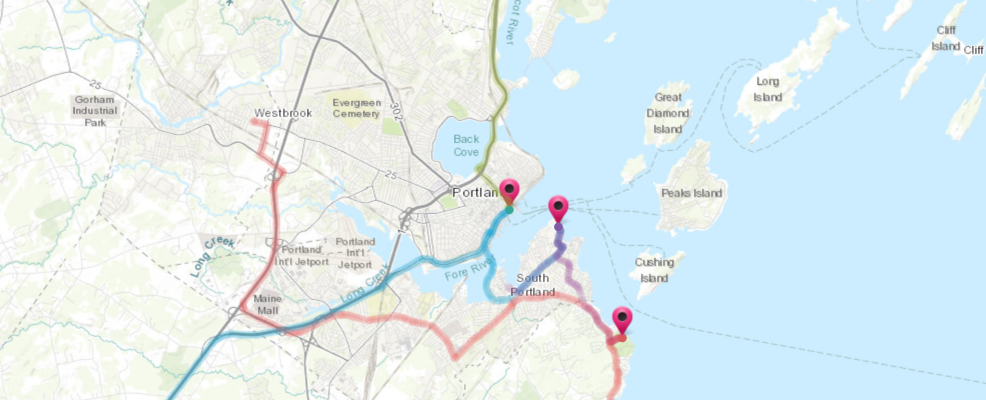

In [8]:
m = gis.map("Portland, ME", zoomlevel=12)
m.add_layer(layer, {"renderer": uvr })
m.add_layer(trace_events_df)
m

#### Let's overlay the traced tracks
The traced tracks represent where a user went after they were in proximity with another traced entity. The transparent layer represents all of the tracks, the opaque colors show the tracks after a user was involved in a proximity event with the root or a derivived entity. You can see the blue tracks become opaque after being near the green tracks.


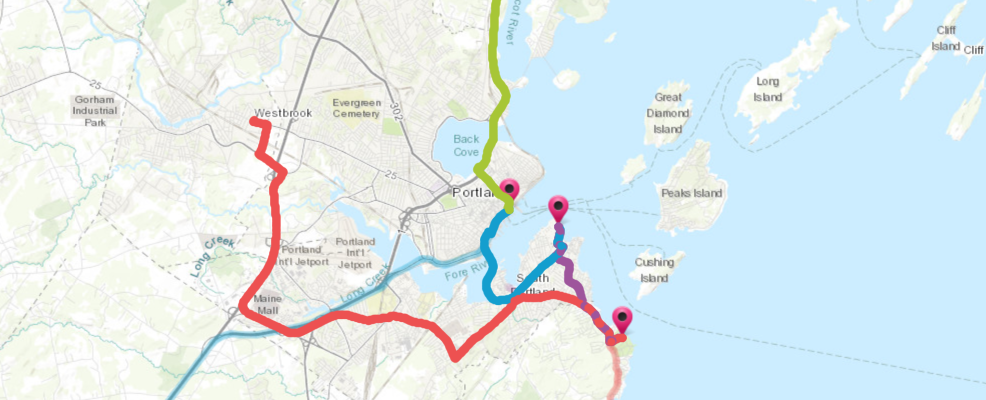

In [10]:
trace_tracks_layer = gis.content.search(output_trace_tracks, sort_field="modified", sort_order="desc")[0].layers[0]
m = gis.map("Portland, ME", zoomlevel=12)
m.add_layer(layer, {"renderer": uvr})
m.add_layer(trace_events_df)
uvr_filled = {"type":"uniqueValue","field1":"entity_id","uniqueValueInfos":[
  {"value":"mgarcia","label":"mgarcia","symbol":{"color":[237,81,81,255],"size":6,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle"}},
  {"value":"johndoe","label":"johndoe","symbol":{"color":[20,158,206,255],"size":6,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle"}},
  {"value":"janedoe","label":"janedoe","symbol":{"color":[167,198,54,255],"size":6,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle"}},
  {"value":"johnsmith","label":"johnsmith","symbol":{"color":[158,85,156,255],"size":6,"angle":0,"xoffset":0,"yoffset":0,"type":"esriSMS","style":"esriSMSCircle"}}
]}
m.add_layer(trace_tracks_layer, {"renderer": uvr_filled})
m